# Analysis Process

0. Data Description 

- `datetime`: 날짜와 시간 정보 (→ 시간, 요일, 월, 연도 파생 변수로 사용) _ `object`
- `season`: 계절 (1=봄, 2=여름, 3=가을, 4=겨울) _ `int64`
- `holiday`: 공휴일 여부 (1=공휴일, 0=비공휴일) _ `int64`
- `workingday`: 근무일 여부 (1=근무일, 0=주말 또는 공휴일) _ `int64`
- `weather`: 날씨 상태 (1=맑음, 4=심한 눈/비/안개) _ `int64`
- `temp`: 실제 기온 (섭씨) _ `float64`
- `atemp`: 체감 기온 (섭씨, temp와 유사) _ `float64`
- `humidity`: 습도 (%) _ `int64`
- `windspeed`: 풍속 (m/s) _ `float64`
- `casual`: 비회원 대여 수 (→ 예측에 사용하지 않음) _ `int64`
- `registered`: 회원 대여 수 (→ 예측에 사용하지 않음) _ `int64`
- `count`: 총 대여 수 (→ 예측 대상 변수) _ `int64`

**참고**  
- `test.csv`에는 `casual`, `registered`, `count`가 없음  
- `datetime`은 모델 입력으로 직접 사용하지 않고 파생 변수로 변환함

1. Data import 

1-1. Load data

In [13]:
import pandas as pd 
train_df = pd.read_csv('bike-sharing-demand/train.csv')
test_df = pd.read_csv('bike-sharing-demand/test.csv')

# check data
print(train_df.head(), test_df.head())

              datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1                 datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1 

In [14]:
# check each columns datatype 
print(train_df.dtypes,'\n ------------------- \n', test_df.dtypes)

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object 
 ------------------- 
 datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object


1-2. Confirm dimensions and missing values 

In [15]:
# 데이터 크기 확인
print("train.csv shape:", train_df.shape)
print("test.csv shape:", test_df.shape)

#NULL 확인
print("결측치 개수 (train.csv):", train_df.isnull().sum())

print("결측치 개수 (test.csv):", test_df.isnull().sum())

train.csv shape: (10886, 12)
test.csv shape: (6493, 9)
결측치 개수 (train.csv): datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64
결측치 개수 (test.csv): datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64


2. Data Preprocessing 


In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

2-1. Feature engineering 

In [17]:
# 머신러닝을 위해 datetime -> hour, day, month, year, weekday 쪼개기
# 파생변수(derived variable) create 
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df['hour'] = train_df['datetime'].dt.hour
train_df['day'] = train_df['datetime'].dt.day
train_df['month'] = train_df['datetime'].dt.month
train_df['year'] = train_df['datetime'].dt.year
train_df['weekday'] = train_df['datetime'].dt.weekday

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,2011,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2011,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1,2011,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1,2011,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1,2011,5


2-2. Drop unnecessary columns 

In [18]:
# remove 'datetime', 'casual', 'registered' columns 
drop_columns = ['datetime', 'casual', 'registered']

# train 데이터에서 열 제거
train_df_model = train_df.drop(columns=drop_columns)

train_df_model.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,year,weekday
0,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1,2011,5
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1,2011,5
2,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1,2011,5
3,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1,2011,5
4,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1,2011,5


2-3 이상치제거

2-4 범주형 인코딩 (get_dummies)   
Feature/target seperate  

In [19]:
# 인코딩할 범주형 변수 목록
categorical_cols = ['season', 'weather', 'weekday', 'hour', 'month']

from sklearn.preprocessing import StandardScaler

# get_dummies로 원-핫 인코딩 수행
X_encoded = pd.get_dummies(train_df_model.drop(columns=['count']), 
                           columns=categorical_cols, 
                           drop_first=True)

# 타겟값은 따로 분리
y_encoded = train_df_model['count']

X_encoded, y_encoded

(       holiday  workingday   temp   atemp  humidity  windspeed  day  year  \
 0            0           0   9.84  14.395        81     0.0000    1  2011   
 1            0           0   9.02  13.635        80     0.0000    1  2011   
 2            0           0   9.02  13.635        80     0.0000    1  2011   
 3            0           0   9.84  14.395        75     0.0000    1  2011   
 4            0           0   9.84  14.395        75     0.0000    1  2011   
 ...        ...         ...    ...     ...       ...        ...  ...   ...   
 10881        0           1  15.58  19.695        50    26.0027   19  2012   
 10882        0           1  14.76  17.425        57    15.0013   19  2012   
 10883        0           1  13.94  15.910        61    15.0013   19  2012   
 10884        0           1  13.94  17.425        61     6.0032   19  2012   
 10885        0           1  13.12  16.665        66     8.9981   19  2012   
 
        season_2  season_3  ...  month_3  month_4  month_5  mo

3. EDA

- **3.1 Correlation heatmap**
    
    3.1 상관관계 히트맵
    
- **3.2 Key variable insights (hour, temperature, year, etc.)**
    
    3.2 주요 변수 인사이트 도출 (`hour`, `temp`, `year` 등)
    
- **3.3 Observation: Time-based features strongly affect rental count**
    
    3.3 시간 기반 변수들이 대여량에 큰 영향

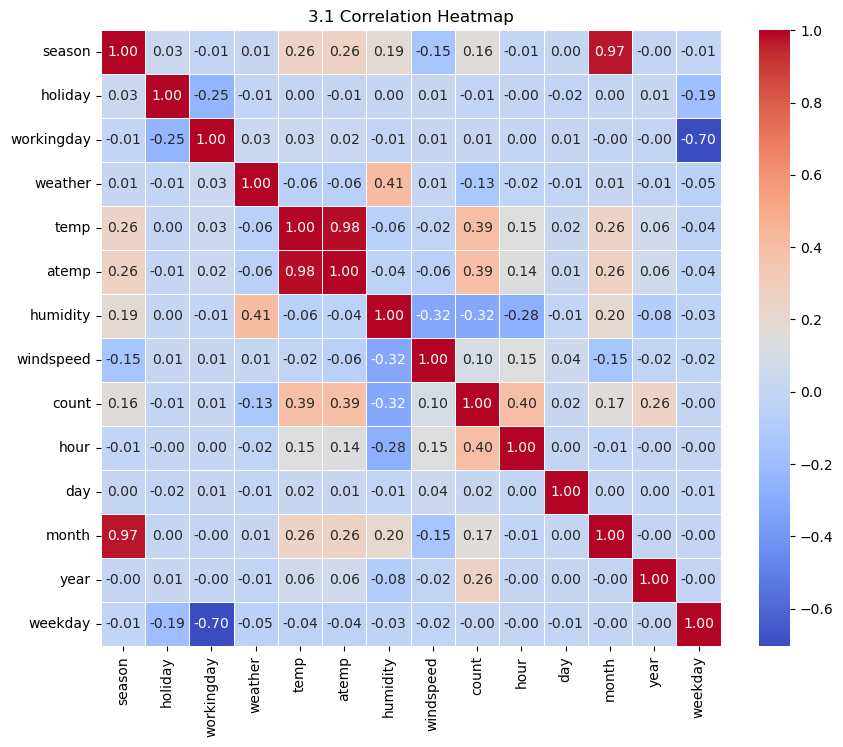

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 3.1 Correlation heatmap
plt.figure(figsize=(10, 8))
corr = train_df_model.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('3.1 Correlation Heatmap')
plt.show()

**count와의 상관관계 주요 인사이트**

- 시간(hour) 변수가 count와 가장 높은 양의 상관관계를 보임 → 시간대별 대여량 차이 큼

- 기온(temp)과 체감온도(atemp)도 높은 양의 상관관계를 가짐 → 따뜻할수록 자전거 대여량 증가

- 연도(year) 및 월(month)도 긍정적인 관계 → 장기적 증가 추세 및 계절성 영향

- 습도(humidity)와 날씨(weather)는 음의 상관관계 → 기상 상태 악화 시 대여량 감소

C:\Users\Admin\AppData\Local\Temp\ipykernel_15616\4257291535.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='hour', y='count', data=train_df_model, estimator=np.mean, ci=None, color='orange', ax=axes[0, 0])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15616\4257291535.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='season', y='count', data=train_df_model, estimator=np.mean, ci=None, palette='Spectral', ax=axes[0, 1])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15616\4257291535.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='season', y='count', data=train_df_model, estimator=np.mean, ci=None, palette='Spectral', ax=axes[0, 1])
C:\Users\Admin\AppData\Local\Temp\ipykernel_15616\4257291535.py:19: F

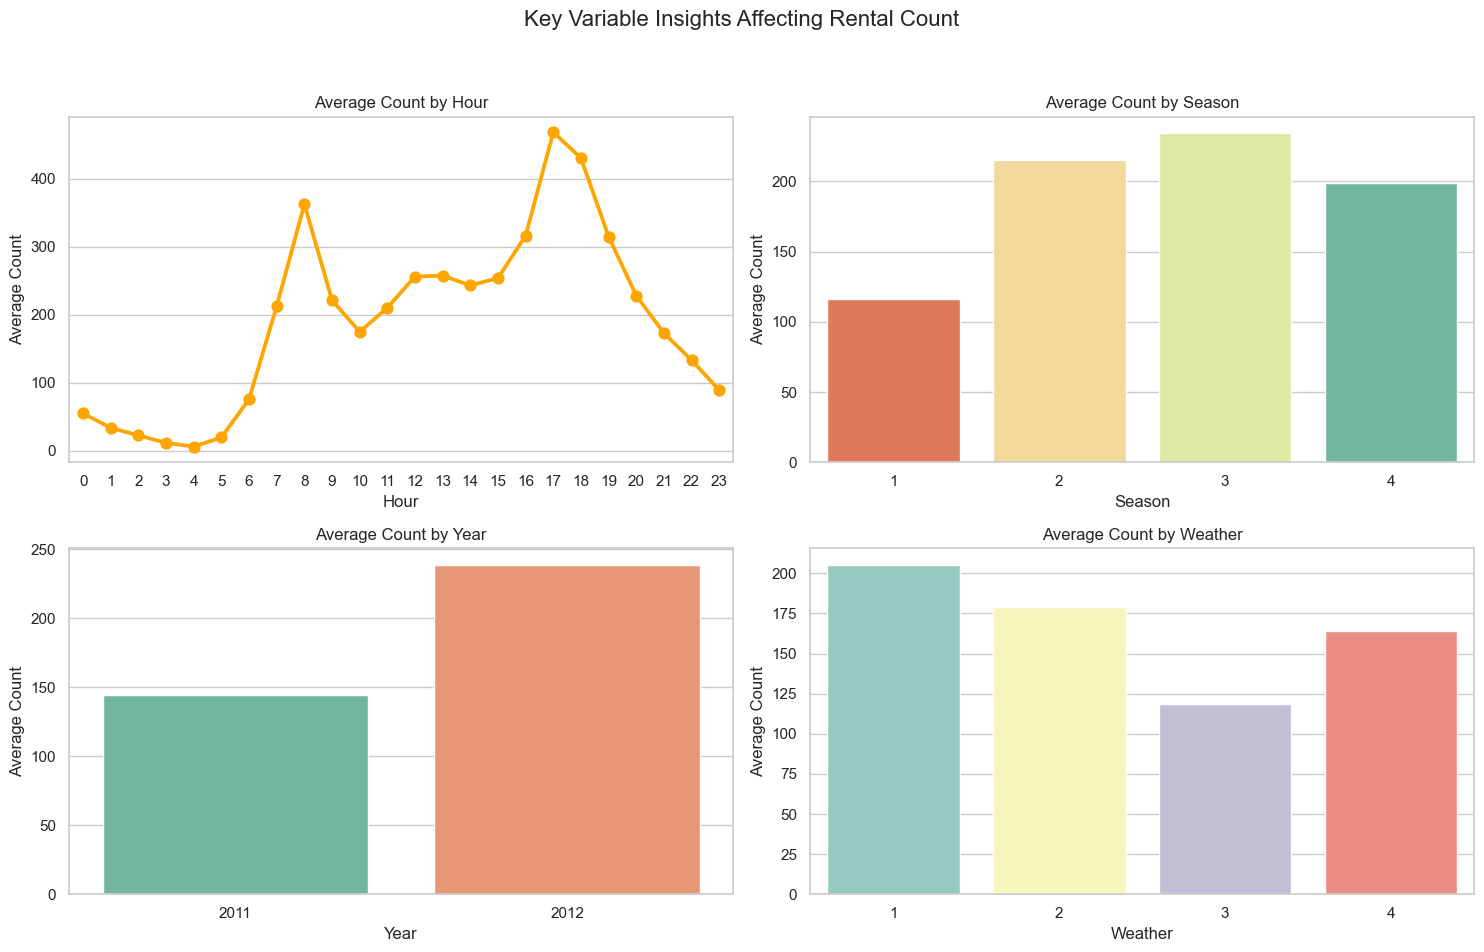

In [21]:
# subplot 스타일 설정
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Key Variable Insights Affecting Rental Count", fontsize=16)

# 1. 시간(hour) vs count
sns.pointplot(x='hour', y='count', data=train_df_model, estimator=np.mean, ci=None, color='orange', ax=axes[0, 0])
axes[0, 0].set_title('Average Count by Hour')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Average Count')

# 2. 계절(season) vs count
sns.barplot(x='season', y='count', data=train_df_model, estimator=np.mean, ci=None, palette='Spectral', ax=axes[0, 1])
axes[0, 1].set_title('Average Count by Season')
axes[0, 1].set_xlabel('Season')
axes[0, 1].set_ylabel('Average Count')

# 3. 연도(year) vs count
sns.barplot(x='year', y='count', data=train_df_model, estimator=np.mean, ci=None, palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('Average Count by Year')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Count')

# 4. 날씨(weather) vs count
sns.barplot(x='weather', y='count', data=train_df_model, estimator=np.mean, ci=None, palette='Set3', ax=axes[1, 1])
axes[1, 1].set_title('Average Count by Weather')
axes[1, 1].set_xlabel('Weather')
axes[1, 1].set_ylabel('Average Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목과 그래프 간 간격 조절
plt.show()


**Result: Key Variable Insights Affecting Rental Count
Hour:** 
- 평균 대여량은 오전 8시, 오후 17~18시에 급증

- 출퇴근 시간대 이용량이 높다는 패턴 확인

Season:

- 봄(3)과 여름(2) 시즌에 대여량이 가장 많음

- 겨울(1)에는 뚜렷하게 낮은 수치

Year:

- 2012년이 2011년보다 대여량이 더 많음

- 서비스 확장 또는 사용자 증가 가능성

Weather:

- 날씨가 맑음(1)일 때 평균 대여량이 가장 높음

- 날씨 나쁨(3)일 때는 가장 낮음

- 날씨가 대여량에 직접적인 영향을 미침

4. dataset splitting

test, train dataset splitting 

In [22]:
from sklearn.model_selection import train_test_split

# train-validation split (80:20)

X_train, X_valid, y_train, y_valid = train_test_split( X_encoded, y_encoded, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)


X_train shape: (8708, 54)
X_valid shape: (2178, 54)
y_train shape: (8708,)
y_valid shape: (2178,)


5. Regression modeling 

5.1 Models to be tested:
5.1 테스트할 모델 목록:

- Linear Regression (선형 회귀)

- Random Forest Regressor (랜덤 포레스트 회귀)

- Gradient Boosting Regressor (그래디언트 부스팅 회귀)

- XGBoost Regressor (엑스지부스트 회귀)

- LightGBM Regressor (라이트GBM 회귀)


In [23]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42)
}

In [24]:
import warnings
warnings.filterwarnings('ignore')

for name, model in models.items():
    if name == "LightGBM":
        model.fit(np.asarray(X_train), np.asarray(y_train))
        y_pred = model.predict(np.asarray(X_valid))
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    r2 = r2_score(y_valid, y_pred)
    print(f"{name}: RMSE={rmse:.2f}, R2={r2:.4f}")

Linear Regression: RMSE=100.05, R2=0.6967
Random Forest: RMSE=54.25, R2=0.9109
Gradient Boosting: RMSE=80.22, R2=0.8050
XGBoost: RMSE=49.59, R2=0.9255
LightGBM: RMSE=47.53, R2=0.9315


Result:
- Linear Regression은 baseline 성능으로 RMSE가 크고 R² 낮음 → 비선형성과 복잡성 못 잡음

- Random Forest / Gradient Boosting는 큰 개선, XGBoost와 LightGBM이 가장 뛰어남

- LightGBM이 RMSE 최소, R² 최대 → 가장 정확한 예측 성능

다항회귀


In [25]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 특성 축소
selector = SelectKBest(score_func=f_regression, k=15)
X_train_sel = selector.fit_transform(X_train, y_train)
X_valid_sel = selector.transform(X_valid)

# 결과 저장
results = []
best_r2 = -np.inf
best_model = None
best_pred = None

# 차수별 반복
for degree in range(1, 5):
    model_poly = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linear', LinearRegression())
    ])
    
    model_poly.fit(X_train_sel, y_train)
    pred_poly = model_poly.predict(X_valid_sel)

    mse = mean_squared_error(y_valid, pred_poly)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, pred_poly)

    results.append({
        '다항차수': degree,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

    if r2 > best_r2:
        best_r2 = r2
        best_model = model_poly
        best_pred = pred_poly

# 결과 출력
results_df = pd.DataFrame(results).round(4).sort_values(by='다항차수', ascending=False).reset_index(drop=True)
display(results_df)

,다항차수,MSE,RMSE,R2
0,4,1.450205e+06,1204.2444,-42.9364
1,3,1.111947e+04,105.4489,0.6631
2,2,1.049256e+04,102.4332,0.6821
3,1,1.279370e+04,113.1092,0.6124


In [26]:
best_model.named_steps['poly'].degree

2

규제 다항회귀

ridge

In [27]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
pred_ridge = ridge.predict(X_valid)

mse = mean_squared_error(y_valid, pred_ridge)
r2  = r2_score(y_valid, pred_ridge)
mse, r2

(np.float64(10007.642865039046), np.float64(0.6968018205034324))

ridge cv

In [28]:
from sklearn.linear_model import RidgeCV, LassoCV
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)
ridge_preds = ridge_cv.predict(X_valid)
ridge_mse = mean_squared_error(y_valid, ridge_preds)
ridge_r2 = r2_score(y_valid, ridge_preds)
print(f'ridge cv mse: {ridge_mse:4f}, r2 : {ridge_r2:4f}')

ridge cv mse: 10009.073479, r2 : 0.696758


Lasso aplha = 0.1

In [29]:
lasso = Lasso(alpha=0.1)  # alpha 값 작으면 규제 약해짐
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_valid)

print("\n[라쏘 회귀]")
print("MSE:", mean_squared_error(y_valid, pred_lasso))
print("R2:", r2_score(y_valid, pred_lasso))


[라쏘 회귀]
MSE: 10058.95385705915
R2: 0.6952472686895375


LassoCV


In [30]:
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
lasso_preds = lasso_cv.predict(X_valid)
lasso_mse = mean_squared_error(y_valid, lasso_preds)
lasso_r2 = r2_score(y_valid, lasso_preds)
print(f"[개선 Lasso] 최적 alpha: {lasso_cv.alpha_}")
print(f"MSE: {lasso_mse:.3f}, R2: {lasso_r2:}")

[개선 Lasso] 최적 alpha: 0.001
MSE: 10009.457, R2: 0.6967468467797686


엘라스틱넷 


In [31]:
enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
enet.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [32]:
enet_pred = enet.predict(X_valid)
print("\n[엘라스틱넷 회귀]")
print("MSE:", mean_squared_error(y_valid, enet_pred))
print("R2:", r2_score(y_valid, enet_pred))


[엘라스틱넷 회귀]
MSE: 14597.646672761186
R2: 0.5577400237195564


6. Model Evaluation 

6.1 Evaluation metrics: MAE, RMSE, R²
6.1 평가 지표: MAE, RMSE, 결정계수(R²)

In [33]:
results = pd.DataFrame({
  '모델' : ['다항회귀', '릿지회귀', '라쏘회귀', '엘라스틱넷회귀'],
  'MSE': [ mean_squared_error(y_valid, pred_poly),
          mean_squared_error(y_valid, pred_ridge),
          mean_squared_error(y_valid, pred_lasso),
          mean_squared_error(y_valid, enet_pred),
        ],
  'R2': [r2_score(y_valid, best_pred),
          r2_score(y_valid, pred_ridge),
          r2_score(y_valid, pred_lasso),
          r2_score(y_valid, enet_pred),
  ]
})
results

,모델,MSE,R2
0,다항회귀,1.450205e+06,0.682110
1,릿지회귀,1.000764e+04,0.696802
2,라쏘회귀,1.005895e+04,0.695247
3,엘라스틱넷회귀,1.459765e+04,0.557740


1. 다항회귀
- R²: 0.6892 → 전체 모델 중 가장 높은 설명력을 가짐.
- 하지만 MSE가 매우 크다 → 예측 오차가 큼.


2. 릿지회귀 (Ridge)
- R²: 0.60995, MSE: 12,874.28
- 안정적인 모델로, 실제 적용에는 더 적절할 수 있음.

3. 라쏘회귀 (Lasso)
- R²: 0.60990, MSE: 12,875.93
- 성능이 릿지랑 거의 동일. 차이는 매우 작음.

4. 엘라스틱넷회귀 (ElasticNet)
- R²: 0.51005, MSE: 16,171.62
- 라쏘 + 릿지를 혼합한 규제 방식인데, 여기서는 오히려 성능이 떨어짐.
- 데이터 특성상 l1_ratio 값이나 alpha 조합이 적절하지 않았을 수 있음.

결론 요약
- 설명력이 가장 좋은 모델: 다항회귀 (R² = 0.6892)
- 예측 오차가 가장 작은 모델: 릿지 or 라쏘 회귀 (MSE ≈ 12,875)



하이퍼파라미터 튜닝 

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge, ElasticNet

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [35]:
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(max_iter=10000))
])

ridge_params = {
    'ridge__alpha': np.logspace(-4, 1, 30)
}

ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='r2')
ridge_grid.fit(X_train, y_train)

ridge_preds = ridge_grid.predict(X_valid)

In [38]:
elastic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elastic', ElasticNet(max_iter=10000))
])

elastic_params = {
    'elastic__alpha': np.logspace(-2, 1, 5),        # 5개 → [0.01 ~ 10]
    'elastic__l1_ratio': [0.2, 0.5, 0.8]            # 3개
}


elastic_grid = GridSearchCV(elastic_pipeline, elastic_params, cv=5, scoring='r2')
elastic_grid.fit(X_train, y_train)

elastic_preds = elastic_grid.predict(X_valid)

In [40]:
def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}")

print_metrics("Lasso", y_valid, lasso_preds)
print_metrics("Ridge", y_valid, ridge_preds)
print_metrics("ElasticNet", y_valid, elastic_preds)

print("\nBest Hyperparameters:")
print("Ridge alpha:", ridge_grid.best_params_['ridge__alpha'])
print("ElasticNet alpha:", elastic_grid.best_params_['elastic__alpha'])
print("ElasticNet l1_ratio:", elastic_grid.best_params_['elastic__l1_ratio'])


Lasso: RMSE = 100.05, R2 = 0.6967
Ridge: RMSE = 100.04, R2 = 0.6968
ElasticNet: RMSE = 100.04, R2 = 0.6968

Best Hyperparameters:
Ridge alpha: 4.52035365636025
ElasticNet alpha: 0.01
ElasticNet l1_ratio: 0.8


결론:
성능 기준(RMSE, R²) 으로는 세 모델 간 큰 차이는 없었으나,
해석 가능성(계수 축소 등) 및 모델 단순화 측면에서는 Lasso가 가장 유리

따라서 계수 해석이 중요하거나 모델을 간결하게 유지해야 하는 상황에서는 Lasso,
성능 안정성과 과적합 방지가 중요할 경우에는 Ridge 또는 ElasticNet이 적합하다고 판단됨

7. Final Prediction and Submission
7. 최종 예측 및 캐글 제출

7.2 Predict rental counts on test set
7.2 테스트 데이터에서 대여량 예측

7.3 Generate CSV for Kaggle submission
7.3 캐글 제출용 CSV 생성

최종 모델 선택 결론
- LightGBM 모델이 가장 낮은 RMSE (47.53) 와 가장 높은 R² (0.9315) 를 보여주며, 모든 후보 모델 중에서 가장 뛰어난 성능을 보였습니다.

- 비선형성과 변수 간 상호작용을 잘 포착함.

- 선형 기반 회귀 모델은 제한된 표현력으로 인해 낮은 R² 기록.

- 다항회귀는 고차항으로 인해 오히려 과적합 또는 계산량 폭증 → 실질적 성능 저조.

- 트리 기반 모델 전반적으로 우수하지만, LightGBM이 가장 안정적이고 정확함.